### LSTM - Input: 'Close/Last', 'SMA', 'MACD', 'Signal_Line', 'RSI'

In [1]:
import pandas as pd
# Load the data
data = pd.read_csv('Data_input_2.csv')

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows with missing values
data.fillna(method='ffill', inplace=True)  # forward fill
data.dropna(inplace=True)  # drop any remaining NaNs


Date           0
Close/Last     0
SMA            0
MACD           0
Signal_Line    0
RSI            0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_13328\2250084885.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # forward fill


In [2]:
data['Date'] = pd.to_datetime(data['Date'])

# Tạo các cột phụ để sắp xếp theo năm, tháng, ngày
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Sắp xếp DataFrame theo năm, sau đó tháng, và cuối cùng là ngày
data.sort_values(['Year', 'Month', 'Day'], inplace=True)

# Xóa các cột phụ nếu không cần thiết
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size  # Đảm bảo rằng tổng số dòng vẫn bằng total_rows

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close/Last', 'SMA', 'MACD', 'Signal_Line', 'RSI']
data_train_copy=data_train[price_columns]
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])

# Chuyển đổi các cột pandas thành mảng NumPy
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (991, 5)
Validation data shape: (123, 5)
Test data shape: (125, 5)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13328\4175297681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_13328\4175297681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[price_columns] = scaler_price.transform(data_val[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_13328\4175297681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [5]:
import numpy as np
# Training data
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (961, 30, 5) (961,)
Validation set shape (93, 30, 5) (93,)
Testing set shape (95, 30, 5) (95,)


In [6]:
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(2**6),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 4))), axis=1))[:,0]

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0606 - val_loss: 0.0060
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

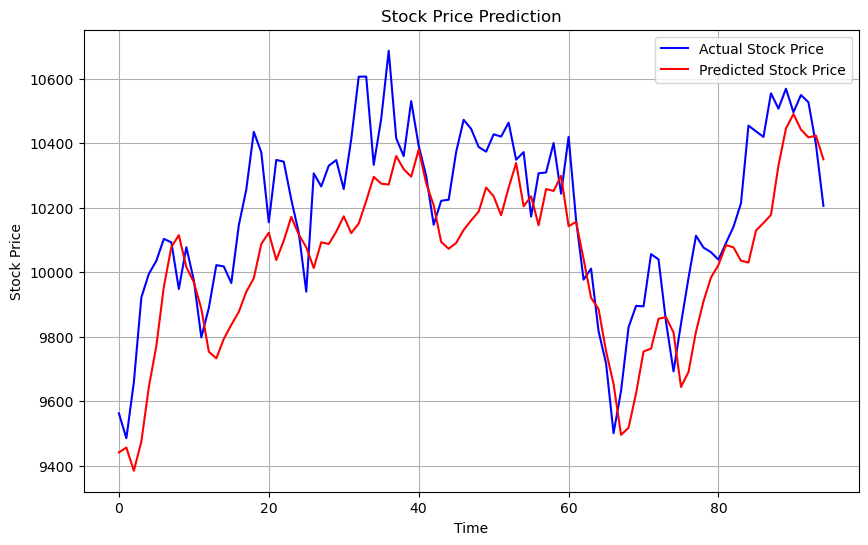

Root Mean Squared Error: 210.7616846061668
Mean Absolute Percentage Error: 0.016891223874812747


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


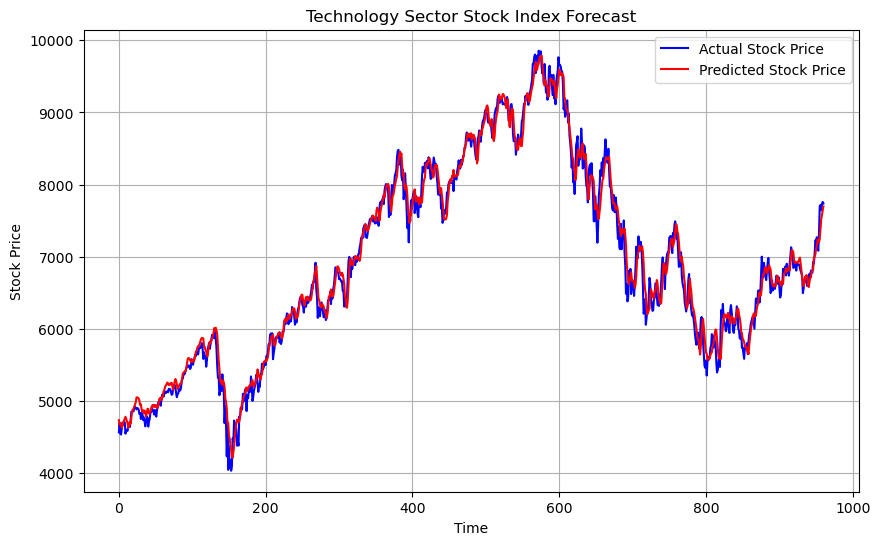

In [8]:
predicted_stock_price_train = model.predict(X_train)
predicted_stock_price_train = scaler_price.inverse_transform(np.concatenate((predicted_stock_price_train, np.zeros((len(predicted_stock_price_train), 4))), axis=1))[:,0]
actual_train_prices = data_train_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_train_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_train, color='red', label='Predicted Stock Price')
plt.title('Technology Sector Stock Index Forecast')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# model.save('1_layerLSTMTechnical.h5')
# import joblib
# joblib.dump(scaler_price, 'scaler_price_tech1lstm.pkl')
# np.save('X_test_tech1ltsm.npy', X_test)